# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Student 1 - __[antoine.bedaton@ulb.be](mailto:antoine.bedaton@ulb.be) - Student ID 459482__
### Student 2 - __[pierre.defraene@ulb.be](mailto:pierre.defraene@ulb.be) - Student ID 463941__
### Student 3 - __[nathan.marotte@ulb.be](mailto:nathan.marotte@ulb.be) - Student ID 459274__

### Video presentation: https://drive.google.com/file/d/14sSOvVklGyE4mWS1J7pWdTvH6LSUp_Ca/view


# Introduction

Using data from Taarifa and the Tanzanian Ministry of Water, we are asked to predict which pump are functional, non functional, or functional but need some repairs. The data contains information about each pump (position, region name, population, type of payment, installator, etc...) and comes in 3 files: 

- training_set_labels: Contains the list of all id followed by their status (functionning, non functionning or needing repairs)

- training_set_values: Contains all the information about each pump with their id that correspond to training_set_labels

- test_set_values: The same structure as training_set_values but for which the status is unknown and that we will have to predict.

First, we will preprocess the data to remove redundent or useless information. For exemple the name of the pump isn't really relevant for guessing if it is working or not, while the name of the constructor is.

Once we reduced the size of the input space, we will run our models on the data, that is training_set_values with their status_group column added.

Our group chose the 3 following models: 

- Decision Tree (library: rpart)
- Neural Network (library: nnet)
- Random Forest (library: randomForest)

We also implemented a fourth model in Part 2: Naive Bayes (library: e1071) as a bonus.

Uncomment and execute the following cell to install all the require libraries.

In [1]:
install_project_packages <- function() {
    install.packages('dummies')
    install.packages('rpart')
    install.packages('rpart.plot')
    install.packages('nnet')
    install.packages('randomForest')
    install.packages('gbm')
    install.packages('e1071')
}

#install_project_packages()

We will be using R in version 3.6.1
This can be checked by executing the following cell:

In [2]:
R.version$version.string

[1] "R version 3.6.3 (2020-02-29)"

Since there is a lot of columns in the data, we will increase the limit of the default max number of columns represented in a print with this cell:

In [3]:
options(repr.matrix.max.cols=100)

We will use the data provided by the competition "Pump it Up: Data Mining the Water Table" available [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/]).

In [4]:
load_data <- function() {
    training_set_labels <<- read.csv(file = 'data/training_set_labels.csv', na.strings = c("", " ", "none", "unknown"))
    test_set_values <<- read.csv(file = 'data/test_set_values.csv', na.strings = c("", " ", "none", "unknown"))
    training_set_values <<- read.csv(file = 'data/training_set_values.csv',  na.strings = c("", " ", "none", "unknown"))
    save_id <<- test_set_values[1]
}
load_data()

# Data preprocessing

## The raw Data
Here is the data as received, as we can see it contains a lot of column and rows, some of which might not be useful.

In [5]:
head(training_set_labels)
head(test_set_values)
head(training_set_values)

,id,status_group
,<int>,<fct>
1,69572,functional
2,8776,functional
3,34310,functional
4,67743,non functional
5,19728,functional
6,9944,functional


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
,<int>,<dbl>,<fct>,<fct>,<int>,<fct>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,50785,0,2013-02-04,Dmdd,1996,DMDD,35.29080,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NA,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
2,51630,0,2013-02-04,Government Of Tanzania,1569,DWE,36.65671,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
3,17168,0,2013-02-01,NA,1567,NA,34.76786,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NA,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
4,45559,0,2013-01-22,Finn Water,267,FINN WATER,38.05805,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NA,GeoData Consultants Ltd,VWC,NA,True,1987,other,other,other,vwc,user-group,NA,NA,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
5,49871,500,2013-03-27,Bruder,1260,BRUDER,35.00612,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NA,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
6,52449,0,2013-03-04,Government Of Tanzania,1685,DWE,36.68528,-3.302420,Masaga,0,Pangani,Masaga,Arusha,2,2,Arusha Rural,Ilkiding'a,200,True,GeoData Consultants Ltd,VWC,Timbolo sambasha TPRI pipe line,True,1990,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
,<int>,<dbl>,<fct>,<fct>,<int>,<fct>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,69572,6000,2011-03-14,Roman,1390,Roman,34.93809,-9.856322,NA,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
2,8776,0,2013-03-06,Grumeti,1399,GRUMETI,34.69877,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NA,GeoData Consultants Ltd,Other,NA,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
3,34310,25,2013-02-25,Lottery Club,686,World vision,37.46066,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
4,67743,0,2013-01-28,Unicef,263,UNICEF,38.48616,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NA,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
5,19728,0,2011-07-13,Action In A,0,Artisan,31.13085,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NA,NA,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
6,9944,20,2011-03-13,Mkinga Distric Coun,0,DWE,39.17280,-4.765587,Tajiri,0,Pangani,Moa/Mwereme,Tanga,4,8,Mkinga,Moa,1,True,GeoData Consultants Ltd,VWC,Zingibali,True,2009,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,other,other,NA,communal standpipe multiple,communal standpipe


## The Preprocessing

Before starting the modeling, we must first process the data. We are given a huge number of columns and rows, some of which are not useful to determine the functioning of the pump. For instance, maybe the name of the pump is not important to guess if it is working or not.

### Removing useless columns
First we will check all the columns and check if, by chance, one column has always the same value. If there exist such a column, we can safely delete it since it doesn't bring any information to the model. One column was found that is always the same value, we will then remove it from the dataset.

In [6]:
remove_always_same_columns <- function(show = FALSE) {
    for (colname in names(training_set_values)) {
        list_of_unique <- unique(training_set_values[colname])
        if (nrow(list_of_unique) == 1 && show){
            print(paste("the column", colname, "has always the same value"))
        }
    }
    # Results: one column `recorded_by` that we can remove
    training_set_values$recorded_by <<- NULL
    test_set_values$recorded_by <<- NULL
}

# Result: we remove maximum one column
before_remove_length <- length(names(training_set_values))
remove_always_same_columns(show = TRUE)
print(paste("We removed", before_remove_length - length(names(training_set_values)), "columns"))

[1] "the column recorded_by has always the same value"
[1] "We removed 1 columns"


Now we can look at the data in a less strict manner. What if for only a few of the entries, we have a different value ? This won't be detected with the above loop, but can be detected manually by checking the number of occurence of the most common value. If it appears, let's say more than 99 % of the time, we assume it is always that value and remove that column.

With the following cell, we see that num_private has almost 99% of the time the same value. Given the huge amount of columns and data, we do not feel that it is necessary to keep that information, it would only make the model more complicated for a slight change in the error rate. Therefore we delete that column.

In [7]:

# Computes the ratio of the value that appear the most compared to the rest of the data

remove_almost_always_same_columns <- function(show = FALSE) {
    frequency_of_most_common <- c()
    for (colname in names(training_set_values)) {
       frequency_of_most_common <- rbind(frequency_of_most_common, max(table(training_set_values[colname]))/59400)
    }

    if (show) {
        df <- data.frame(names(training_set_values), frequency_of_most_common)
        df <- df[order(df$frequency_of_most_common, decreasing=TRUE),]
        IRdisplay::display(df)
    }

    training_set_values$num_private <<- NULL
    test_set_values$num_private <<- NULL

    
}

before_remove_length <- length(names(training_set_values))

remove_almost_always_same_columns(show = TRUE)

print(paste("We removed", before_remove_length - length(names(training_set_values)), "columns"))

,names.training_set_values.,frequency_of_most_common
,<fct>,<dbl>
10,num_private,9.872559e-01
28,management_group,8.836700e-01
19,public_meeting,8.587710e-01
31,water_quality,8.555219e-01
32,quality_group,8.555219e-01
37,source_class,7.709428e-01
2,amount_tsh,7.009933e-01
27,management,6.819360e-01
22,permit,6.540741e-01


[1] "We removed 1 columns"


## Looking at the corelation between columns

When looking through the data, we found multiple columns that were repeated. We suspected that `quantity` and `quantity_group` were highly corolated, so we ran the following command to check directly if there is a bijection for every variable.

In [8]:
table(training_set_values$quantity, training_set_values$quantity_group)

              
                 dry enough insufficient seasonal
  dry           6246      0            0        0
  enough           0  33186            0        0
  insufficient     0      0        15129        0
  seasonal         0      0            0     4050

It appears that when `quantity` is `dry`, 100% of the time `quantity_group` is also dry. Those two columns have a corelation of 100%, it means one of the two is redundant and can safely be removed.

We could then do that for all the combination of columns, but this isn't efficient and we can decide by ourselves by looking at what the columns represent, and test for corelation between them. This can be done via `chiqs.test` of the contingency table of the two columns. 

For exemple with `quantity` and `quantity_group` compared to `quantity` and `payment_type`.

In [9]:
chisq.test(table(training_set_values$quantity, training_set_values$quantity_group))
table(training_set_values$quantity, training_set_values$quantity_group)
chisq.test(table(training_set_values$quantity, training_set_values$payment_type))
table(training_set_values$quantity, training_set_values$payment_type)


	Pearson's Chi-squared test

data:  table(training_set_values$quantity, training_set_values$quantity_group)
X-squared = 175833, df = 9, p-value < 2.2e-16


              
                 dry enough insufficient seasonal
  dry           6246      0            0        0
  enough           0  33186            0        0
  insufficient     0      0        15129        0
  seasonal         0      0            0     4050


	Pearson's Chi-squared test

data:  table(training_set_values$quantity, training_set_values$payment_type)
X-squared = 1723.9, df = 15, p-value < 2.2e-16


              
               annually monthly never pay on failure other per bucket
  dry               179     362      3133        347    72        583
  enough           2678    5262     13067       2170   670       5810
  insufficient      563    2318      6731       1076   192       2246
  seasonal          203     332      2196        298   114        299

We see that with a high X-squared value and a low degree of freedom, we get a high correlation. We can still use the `table` command to double check.

We have to be careful with Chi-squared test since the degree of freedom also influences X-squared value. If we have a high degree of freedom, we might have more problems interpreting the X-square value because of that.

We now have a way to check efficiently if two columns are correlated, so we will use that with the one we suspect are. We can also use the contingency table if we are not sure that they are.

## Feature engineering

For this part, we will check our model and see if we cannot create new features for the data. For exemple we could merge `pay monthly` and `pay annualy` into `periodic_payment`.
However we didn't find that very useful for the data presented.

## Feature selection
We want to look at the correlation between every input and the output. to do so we will make a `chiqs.test` for every column. This will give us an idea of how important a column is for predicting the `status_group`.

A very high correlation (high X-squared, low df) between one column and the prediction means a very easy way to get a high score which is obviously what we do not find since it is the combination of columns that can give us a good idea on the status of the pump.

In [10]:
test_correlation <- cbind(training_set_values,training_set_labels[2])

chisq.test(table(test_correlation$amount_tsh, test_correlation$status_group))
chisq.test(table(test_correlation$date_recorded, test_correlation$status_group))
chisq.test(table(test_correlation$funder, test_correlation$status_group))
chisq.test(table(test_correlation$gps_height, test_correlation$status_group))
chisq.test(table(test_correlation$installer, test_correlation$status_group))
chisq.test(table(test_correlation$longitude, test_correlation$status_group))
chisq.test(table(test_correlation$latitude, test_correlation$status_group))
chisq.test(table(test_correlation$wpt_name, test_correlation$status_group))
chisq.test(table(test_correlation$basin, test_correlation$status_group))
chisq.test(table(test_correlation$subvillage, test_correlation$status_group))
chisq.test(table(test_correlation$region, test_correlation$status_group))
chisq.test(table(test_correlation$region_code, test_correlation$status_group))
chisq.test(table(test_correlation$district_code, test_correlation$status_group))
chisq.test(table(test_correlation$lga, test_correlation$status_group))
chisq.test(table(test_correlation$ward, test_correlation$status_group))
chisq.test(table(test_correlation$population, test_correlation$status_group))
chisq.test(table(test_correlation$public_meeting, test_correlation$status_group))
chisq.test(table(test_correlation$scheme_management, test_correlation$status_group))
chisq.test(table(test_correlation$scheme_name, test_correlation$status_group))
chisq.test(table(test_correlation$permit, test_correlation$status_group))
chisq.test(table(test_correlation$construction_year, test_correlation$status_group))
chisq.test(table(test_correlation$extraction_type, test_correlation$status_group))
chisq.test(table(test_correlation$management, test_correlation$status_group))
chisq.test(table(test_correlation$payment, test_correlation$status_group))
chisq.test(table(test_correlation$water_quality, test_correlation$status_group))
chisq.test(table(test_correlation$quantity, test_correlation$status_group))
chisq.test(table(test_correlation$source, test_correlation$status_group))
chisq.test(table(test_correlation$waterpoint_type, test_correlation$status_group))

Warning message in chisq.test(table(test_correlation$amount_tsh, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$amount_tsh, test_correlation$status_group)
X-squared = 4307.2, df = 194, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$date_recorded, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$date_recorded, test_correlation$status_group)
X-squared = 5005.7, df = 710, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$funder, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$funder, test_correlation$status_group)
X-squared = 14173, df = 3792, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$gps_height, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$gps_height, test_correlation$status_group)
X-squared = 6279.7, df = 4854, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$installer, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$installer, test_correlation$status_group)
X-squared = 14721, df = 4286, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$longitude, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$longitude, test_correlation$status_group)
X-squared = 112780, df = 115030, p-value = 1


Warning message in chisq.test(table(test_correlation$latitude, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$latitude, test_correlation$status_group)
X-squared = 112782, df = 115032, p-value = 1


Warning message in chisq.test(table(test_correlation$wpt_name, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$wpt_name, test_correlation$status_group)
X-squared = 75575, df = 74796, p-value = 0.02224



	Pearson's Chi-squared test

data:  table(test_correlation$basin, test_correlation$status_group)
X-squared = 1921, df = 16, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$subvillage, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$subvillage, test_correlation$status_group)
X-squared = 55053, df = 38572, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  table(test_correlation$region, test_correlation$status_group)
X-squared = 4794.6, df = 40, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$region_code, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$region_code, test_correlation$status_group)
X-squared = 5157.4, df = 52, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$district_code, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$district_code, test_correlation$status_group)
X-squared = 1673.5, df = 38, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$lga, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$lga, test_correlation$status_group)
X-squared = 11530, df = 248, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$ward, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$ward, test_correlation$status_group)
X-squared = 26145, df = 4182, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$population, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$population, test_correlation$status_group)
X-squared = 4480, df = 2096, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  table(test_correlation$public_meeting, test_correlation$status_group)
X-squared = 302.18, df = 2, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$scheme_management, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$scheme_management, test_correlation$status_group)
X-squared = 1887.1, df = 22, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$scheme_name, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$scheme_name, test_correlation$status_group)
X-squared = 21616, df = 5388, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  table(test_correlation$permit, test_correlation$status_group)
X-squared = 67.79, df = 2, p-value = 1.904e-15


Warning message in chisq.test(table(test_correlation$construction_year, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$construction_year, test_correlation$status_group)
X-squared = 4098.4, df = 108, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$extraction_type, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$extraction_type, test_correlation$status_group)
X-squared = 7365.6, df = 34, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  table(test_correlation$management, test_correlation$status_group)
X-squared = 2015.2, df = 20, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  table(test_correlation$payment, test_correlation$status_group)
X-squared = 3334.7, df = 10, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$water_quality, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$water_quality, test_correlation$status_group)
X-squared = 575.43, df = 12, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  table(test_correlation$quantity, test_correlation$status_group)
X-squared = 11039, df = 6, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  table(test_correlation$source, test_correlation$status_group)
X-squared = 2622.7, df = 16, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$waterpoint_type, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  table(test_correlation$waterpoint_type, test_correlation$status_group)
X-squared = 7450.3, df = 12, p-value < 2.2e-16


Now, we will look at pairs of columns that seem similar and compare their contingency table. 

The columns mentionned in the next cell are removed because of their contigency table with another column. We removed them if it indicated that they brought the same or less information to the model.

In [11]:
remove_highly_correlated_column_in_pair <- function() {
    # print(table(training_set_values$waterpoint_type_group, training_set_values$waterpoint_type))
    training_set_values$waterpoint_type_group <<- NULL
    test_set_values$waterpoint_type_group <<- NULL
    
    # print(table(training_set_values$source_type, training_set_values$source_class))
    training_set_values$source_class <<- NULL
    test_set_values$source_class <<- NULL
    
    # print(table(training_set_values$source, training_set_values$source_type))
    training_set_values$source_type <<- NULL
    test_set_values$source_type <<- NULL
    
    # print(table(training_set_values$water_quality, training_set_values$quality_group))
    training_set_values$quality_group <<- NULL
    test_set_values$quality_group <<- NULL
    
    # print(table(training_set_values$quantity, training_set_values$quantity_group))
    training_set_values$quantity_group <<- NULL
    test_set_values$quantity_group <<- NULL
    
    # print(table(training_set_values$extraction_type, training_set_values$extraction_type_group))
    training_set_values$extraction_type_group <<- NULL
    test_set_values$extraction_type_group <<- NULL
    
    # print(table(training_set_values$extraction_type, training_set_values$extraction_type_class))
    training_set_values$extraction_type_class <<- NULL
    test_set_values$extraction_type_class <<- NULL
    
    # print(table(training_set_values$payment, training_set_values$payment_type))
    training_set_values$payment_type <<- NULL
    test_set_values$payment_type <<- NULL
    
    # print(table(training_set_values$management, training_set_values$management_group))
    training_set_values$management_group <<- NULL
    test_set_values$management_group <<- NULL
}

big_removal <- function() {
        ################# MANUAL TEST #########################
    training_set_values$longitude <<- NULL
    test_set_values$longitude <<- NULL
    training_set_values$latitude <<- NULL
    test_set_values$latitude <<- NULL
    training_set_values$funder <<- NULL
    test_set_values$funder <<- NULL
    training_set_values$region <<- NULL
    test_set_values$region <<- NULL
    training_set_values$district_code <<- NULL
    test_set_values$district_code <<- NULL
    training_set_values$ward <<- NULL
    test_set_values$ward <<- NULL
    training_set_values$lga <<- NULL
    test_set_values$lga <<- NULL
    training_set_values$population <<- NULL
    test_set_values$population <<- NULL
    training_set_values$public_meeting <<- NULL
    test_set_values$public_meeting <<- NULL
    training_set_values$extraction_type_class <<- NULL
    test_set_values$extraction_type_class <<- NULL
    training_set_values$scheme_name <<- NULL
    test_set_values$scheme_name <<- NULL
    training_set_values$subvillage <<- NULL
    test_set_values$subvillage <<- NULL
    training_set_values$wpt_name <<- NULL
    test_set_values$wpt_name <<- NULL
    training_set_values$installer <<- NULL
    test_set_values$installer <<- NULL
    training_set_values$date_recorded <<- NULL
    test_set_values$date_recorded <<- NULL
    training_set_values$id <<- NULL
    test_set_values$id <<- NULL
}
before_remove_length <- length(names(training_set_values))

remove_highly_correlated_column_in_pair()

print(paste("We removed", before_remove_length - length(names(training_set_values)), "columns"))

[1] "We removed 9 columns"


## Missing value imputation
In this part, we will have to replace missing value by something else. One approach could be to simply remove rows that are missing a value if they are not so common, otherwise we can also take the average of that column, or replace the missing value with the most common value. 

We chose to replace the empty value with a new category: `unknown`. This might be a  problem for the model since for exemple, it could indicate that all rows which `funder` is `unkown` are broken, but this could actually be truthful since, indeed, if the funder is unknown, maybe the pump has more chance of breaking

This will be done for all the columns that contain text entries, since there isn't missing data for numbers.

In [12]:
replace_na_with_unknown <- function() {
    i <- sapply(training_set_values, is.factor)
    training_set_values[i] <<- lapply(training_set_values[i], as.character)
    training_set_values[is.na(training_set_values)] <<- "unknown"
    training_set_values[i] <<- lapply(training_set_values[i], as.factor)
}
replace_na_with_unknown()

## Feature selection and end of preprocessing

We need to transform also categorical variable with 'one-hot-encoding'. To do so, we will use `dummies` package. 

To ensure that we do not miss a categorical variable, we merge the training set and the test set and then dummify certain non numeric columns. We chose to only dummify `water_quality` and `quantity` and removed all the others text columns since they can take too many different values.

We will drop all the other text variables, since most of them are just names of regions/pumps/etc ... It also removes the `funder` column. We couldn't dummify that variable since there are more than 19000 different funders.

In [13]:
library(dummies)

dummify <- function() {
    
    full_dataset <- rbind(training_set_values,test_set_values) # Merge train and test

    non_numeric_variables <- which(sapply(full_dataset,class)=="factor") # take only factor/text variable

    data_non_numeric <- full_dataset[,non_numeric_variables]
    data_numeric <- full_dataset[,-non_numeric_variables]

    variables_to_dummify <- c("water_quality", "quantity") # variable to transform
    data_factor_onehot <- dummy.data.frame(data_non_numeric[,variables_to_dummify], sep="_")
    gc()

    full_dataset_dummified <- cbind(data_numeric,data_factor_onehot)

    # Fix names of the columns after dummies operation
    names(full_dataset_dummified) <- gsub(" ", "_", names(full_dataset_dummified))
    names(full_dataset_dummified) <- make.names(names(full_dataset_dummified))

    # resplit data
    # data_train
    training_set_values <<- full_dataset_dummified[1:nrow(training_set_values),]
    training_set_values <<- cbind(training_set_values, training_set_labels[2])



    # data_test
    test_set_values <<- full_dataset_dummified[ (1+nrow(training_set_values)):nrow(full_dataset_dummified),]
}

# This method should only be used for the random forest model, you may change the value inside
# memory.limit(byte) in order to satisfy your ram amount
extreme_dummify <- function() {
    full_dataset <- rbind(training_set_values,test_set_values) # Merge train and test

    non_numeric_variables <- which(sapply(full_dataset,class)=="factor") # take only factor/text variable

    data_non_numeric <- full_dataset[,non_numeric_variables]
    data_numeric <- full_dataset[,-non_numeric_variables]

    gc()
    memory.limit(999999999999)
    variables_to_dummify <- names(data_non_numeric)
    data_factor_onehot <- dummy.data.frame(data_non_numeric[,variables_to_dummify], sep="_")
    gc()

    full_dataset_dummified <- cbind(data_numeric,data_factor_onehot)

    # Fix names of the columns after dummies operation
    names(full_dataset_dummified) <- gsub(" ", "_", names(full_dataset_dummified))
    names(full_dataset_dummified) <- make.names(names(full_dataset_dummified))

    # resplit data
    # data_train
    training_set_values <<- full_dataset_dummified[1:nrow(training_set_values),]
    training_set_values <<- cbind(training_set_values, training_set_labels[2])

    # data_test
    test_set_values <<- full_dataset_dummified[ (1+nrow(training_set_values)):nrow(full_dataset_dummified),]
}


# dummify()


dummies-1.5.6 provided by Decision Patterns




Now we can create a function that will load and preprocess the data

In [14]:
preprocessing <- function() {
    load_data()
    remove_always_same_columns()
    remove_almost_always_same_columns()
    remove_highly_correlated_column_in_pair()
    big_removal()
    replace_na_with_unknown()
    dummify()
}
big_preprocessing <- function() {
    load_data()
    remove_always_same_columns()
    remove_almost_always_same_columns()
    remove_highly_correlated_column_in_pair()
    big_removal()
    replace_na_with_unknown()
    extreme_dummify()
}
load_data()

print("Heads of data before preprocessing")
head(training_set_labels)
head(test_set_values)
head(training_set_values)

preprocessing()


print("Heads of data after preprocessing")
head(training_set_labels)
head(test_set_values)
head(training_set_values)

[1] "Heads of data before preprocessing"


,id,status_group
,<int>,<fct>
1,69572,functional
2,8776,functional
3,34310,functional
4,67743,non functional
5,19728,functional
6,9944,functional


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
,<int>,<dbl>,<fct>,<fct>,<int>,<fct>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,50785,0,2013-02-04,Dmdd,1996,DMDD,35.29080,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NA,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
2,51630,0,2013-02-04,Government Of Tanzania,1569,DWE,36.65671,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
3,17168,0,2013-02-01,NA,1567,NA,34.76786,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NA,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
4,45559,0,2013-01-22,Finn Water,267,FINN WATER,38.05805,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NA,GeoData Consultants Ltd,VWC,NA,True,1987,other,other,other,vwc,user-group,NA,NA,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
5,49871,500,2013-03-27,Bruder,1260,BRUDER,35.00612,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NA,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
6,52449,0,2013-03-04,Government Of Tanzania,1685,DWE,36.68528,-3.302420,Masaga,0,Pangani,Masaga,Arusha,2,2,Arusha Rural,Ilkiding'a,200,True,GeoData Consultants Ltd,VWC,Timbolo sambasha TPRI pipe line,True,1990,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
,<int>,<dbl>,<fct>,<fct>,<int>,<fct>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,69572,6000,2011-03-14,Roman,1390,Roman,34.93809,-9.856322,NA,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
2,8776,0,2013-03-06,Grumeti,1399,GRUMETI,34.69877,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NA,GeoData Consultants Ltd,Other,NA,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
3,34310,25,2013-02-25,Lottery Club,686,World vision,37.46066,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
4,67743,0,2013-01-28,Unicef,263,UNICEF,38.48616,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NA,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
5,19728,0,2011-07-13,Action In A,0,Artisan,31.13085,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NA,NA,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
6,9944,20,2011-03-13,Mkinga Distric Coun,0,DWE,39.17280,-4.765587,Tajiri,0,Pangani,Moa/Mwereme,Tanga,4,8,Mkinga,Moa,1,True,GeoData Consultants Ltd,VWC,Zingibali,True,2009,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,other,other,NA,communal standpipe multiple,communal standpipe


Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"


[1] "Heads of data after preprocessing"


,id,status_group
,<int>,<fct>
1,69572,functional
2,8776,functional
3,34310,functional
4,67743,non functional
5,19728,functional
6,9944,functional


,amount_tsh,gps_height,region_code,construction_year,water_quality_coloured,water_quality_fluoride,water_quality_fluoride_abandoned,water_quality_milky,water_quality_salty,water_quality_salty_abandoned,water_quality_soft,water_quality_unknown,water_quality_NA,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,quantity_NA
,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
59401,0,1996,21,2012,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
59402,0,1569,2,2000,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
59403,0,1567,13,2010,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
59404,0,267,80,1987,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
59405,500,1260,10,2000,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
59406,0,1685,2,1990,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


,amount_tsh,gps_height,region_code,construction_year,water_quality_coloured,water_quality_fluoride,water_quality_fluoride_abandoned,water_quality_milky,water_quality_salty,water_quality_salty_abandoned,water_quality_soft,water_quality_unknown,water_quality_NA,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,quantity_NA,status_group
,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
1,6000,1390,11,1999,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,functional
2,0,1399,20,2010,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,functional
3,25,686,21,2009,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,functional
4,0,263,90,1986,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,non functional
5,0,0,18,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,functional
6,20,0,4,2009,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,functional


# Model selection

As stated in the introduction, we used the four following models/libraries: 

- Decision Tree (library: rpart)
- Neural Network (library: nnet)
- Random Forest (library: randomForest)
- Naive Bayes (library: e1071)



## Model 1: Decision Tree
We chose to use Decision tree since it is one of the simplest machine learning technique, and also that it can help us build intuition about what makes a pump functional or not. 

The decision tree produced might or might not be relevant to the real case problem, but it will be useful to predict the data of the model.

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"


,id,status_group
,<int>,<fct>
59401,50785,functional
59402,51630,functional
59403,17168,functional
59404,45559,non functional
59405,49871,functional
59406,52449,functional



FALSE  TRUE 
 3126 11724 

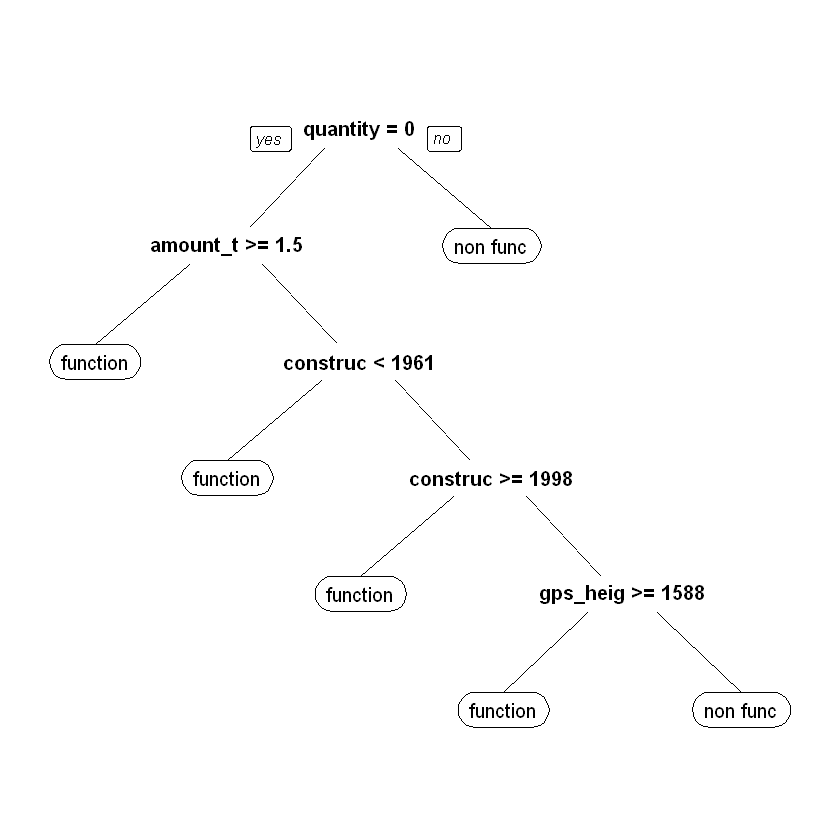

In [15]:
library(rpart)
library(rpart.plot)

preprocessing()  # Preprocessing
decision_tree_model <- rpart(status_group~., data = training_set_values, method = 'class')  # Modelling

decision_tree_prediction <- cbind(save_id, predict(decision_tree_model, test_set_values, type = 'class'))  # Predicting
names(decision_tree_prediction) <- c("id", "status_group")  # Reformatting

# Printing
prp(decision_tree_model)
head(decision_tree_prediction)
table(decision_tree_prediction["status_group"] == "functional")

# Saving
write.csv(decision_tree_prediction,"predictions/decisionTree.csv",row.names = FALSE)

## Model 2: Neural Network

Given how popular Neural Networks are, we will also use it for the data. However we do not expect enormous result with this model since Neural Network work better for other type of problems.

In [16]:
library(nnet)

preprocessing()  # Preprocessing

nnet_model <- nnet(status_group~., data = training_set_values, size = 32, decay=5e-4, maxit=500,
                  MaxNWts=10000)  # Modelling

nnet_prediction <- cbind(save_id, predict(nnet_model, test_set_values, type= 'class'))  # Predicting
names(nnet_prediction) <- c("id", "status_group")  # Reformatting

# Printing
head(nnet_prediction)
table(nnet_prediction["status_group"] == "functional")

# Saving
write.csv(nnet_prediction,"predictions/NeuralNetwork.csv",row.names = FALSE)

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"


# weights:  739
initial  value 64370.443833 
iter  10 value 52976.273055
iter  20 value 51074.353071
iter  30 value 49954.319020
iter  40 value 49281.053966
iter  50 value 48930.777145
iter  60 value 48729.427637
iter  70 value 48574.912494
iter  80 value 48481.068109
iter  90 value 48350.275535
iter 100 value 48285.094896
iter 110 value 48180.179082
iter 120 value 48110.143375
iter 130 value 48016.584467
iter 140 value 47907.993350
iter 150 value 47853.036597
iter 160 value 47770.126601
iter 170 value 47732.252177
iter 180 value 47562.594436
iter 190 value 47416.769496
iter 200 value 47029.252456
iter 210 value 46511.057384
iter 220 value 46331.526102
iter 230 value 45994.835612
iter 240 value 45754.096639
iter 250 value 45691.965140
iter 260 value 45628.713770
iter 270 value 45578.536837
iter 280 value 45534.143242
iter 290 value 45446.173597
iter 300 value 45415.866140
iter 310 value 45260.081130
iter 320 value 45224.135145
iter 330 value 45204.199447
iter 340 value 45189.910525
ite

,id,status_group
,<int>,<fct>
1,50785,functional
2,51630,functional
3,17168,functional
4,45559,non functional
5,49871,functional
6,52449,functional



FALSE  TRUE 
 2784 12066 

## Model 3: Random Forest

We chose this model because it is the continuity of decision tree and we think it is a good way to achieve a correct prediction.

In [17]:
library("randomForest")
preprocessing()  # Preprocessing

rf_model<- randomForest(status_group~., data = training_set_values, ntrees = 500)  # Modelling
rf_model
rf_prediction <- cbind(save_id, predict(rf_model, test_set_values, type = 'class'))  # Predicting
names(rf_prediction) <- c("id", "status_group")  # Reformatting

# Printing
head(rf_prediction)
table(rf_prediction["status_group"] == "functional")

# Saving
write.csv(rf_prediction,"predictions/randomForest.csv",row.names = FALSE)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"



Call:
 randomForest(formula = status_group ~ ., data = training_set_values,      ntrees = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 29.8%
Confusion matrix:
                        functional functional needs repair non functional
functional                   30338                       8           1913
functional needs repair       3807                      28            482
non functional               11487                       3          11334
                        class.error
functional               0.05954927
functional needs repair  0.99351401
non functional           0.50341746

,id,status_group
,<int>,<fct>
59401,50785,functional
59402,51630,functional
59403,17168,functional
59404,45559,non functional
59405,49871,functional
59406,52449,functional



FALSE  TRUE 
 3213 11637 

The cell below takes a lot of RAM and takes some time to run. The reason is because we dummify 15 variables, so the vector is huge.

In [18]:
# # Extreme random forest
# library("randomForest")

# big_preprocessing()  # Preprocessing
# # training_set_values <<- cbind(training_set_values, training_set_labels[2])

# rf_model<- randomForest(status_group~., data = training_set_values, ntrees = 2000)  # Modelling
# rf_model

# rf_prediction <- cbind(save_id, predict(rf_model, test_set_values, type = 'class'))  # Predicting
# names(rf_prediction) <- c("id", "status_group")  # Reformatting

# # Printing
# head(rf_prediction)
# table(rf_prediction["status_group"] == "functional")

# # Saving
# write.csv(rf_prediction,"predictions/extreme_randomForest",row.names = FALSE)

## Model 4: Naive Bayes
We also chose as a bonus to use Naive Bayes. This models is similar to the previous one except that it assumes all the column are independant, this is what gives it its naive name.


In [19]:
library(e1071)

nb_model <- naiveBayes(status_group~., data=training_set_values)

nb_prediction <- cbind(save_id, predict(nb_model, newdata = test_set_values))  # Predicting
names(nb_prediction) <- c("id", "status_group")  # Reformatting

# Printing
head(nb_prediction)
table(nb_prediction["status_group"] == "functional")

write.csv(nb_prediction,"predictions/naive_bayes.csv",row.names = FALSE)

,id,status_group
,<int>,<fct>
1,50785,functional needs repair
2,51630,functional needs repair
3,17168,functional needs repair
4,45559,non functional
5,49871,functional needs repair
6,52449,functional needs repair



FALSE  TRUE 
14420   430 

# Alternative models

As an alternative model, we used the Gradient Boosting Model library (gbm). It also works with tree and we set the value to 500. However we can increase that value to have a better prediction but it will increase the computing time. 5000 would be a sufficient value for a really precise classification



In [ ]:
# GRADIENT BOOSTING
library(gbm)
n <- 500

preprocessing()  # Preprocessing

gm_model <- gbm(formula = status_group~., distribution = "multinomial", data = training_set_values, n.trees = n,
            interaction.depth = 4, shrinkage = 0.01, cv.folds = 10, n.minobsinnode = 10)  # Modelling
print(gm_model)
gm_prediction <- predict(gm_model, newdata = test_set_values, type="response", n.trees = n)  # Predicting
print(dim(gm_prediction))
# Reformatting
status_group <- colnames(gm_prediction)[apply(gm_prediction, 1, which.max)]
gm_prediction <- cbind(save_id, status_group)


# Printing
head(gm_prediction)
table(gm_prediction["status_group"] == "functional")

# Saving
write.csv(gm_prediction,"predictions/gradient_boosting.csv",row.names = FALSE)

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message:
"Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk."
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 13: water_quality_NA has no variation."
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 19: quantity_NA has no variation."


# Conclusions

We found that random forest works best among our 5 models, and we think it would be even better with more accurate data (for exemple pressure sensors, temperature sensors, etc ... ). Decision Tree and gbm also worked well since they are based on the same principle

Neural Network is also be a good candidate for this type of problem because it can create abstraction about data in a smarter way than Nearest Neighbor to understand that geographically close waterpumps might or might not suffer the same problem

This project helped us to learn how to use the machine learning tools at our disposal, hiding the model behind a simple function call. This is a good thing to program very easily machine learning classification but the documentation doesn't provide us with how the model actually works.